# Library import

In [116]:
import pandas as pd
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Loading saved models

In [133]:

model_xgb = joblib.load(r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_xgb.pkl') #Load model
model_lnr = joblib.load(r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_lnr.pkl') #Load model
model_nn = joblib.load(r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_nn.pkl') #Load model
model_lstm = joblib.load(r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_lstm.pkl') #Load model
model_gru = joblib.load(r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_gru.pkl') #Load model

# Loading train and test data

In [118]:
# features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'MA5', 'MA10', 'Volatility']
features = ['Open', 'High', 'Low', 'Close','MA10', 'Target']

In [119]:
# train_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_train.csv')[features]
test_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_test.csv')
 

In [120]:
def clean_data(ddf):
  # Drop unnamed index column if present
  ddf = ddf.loc[:, ~ddf.columns.str.contains('^Unnamed')]

  # Convert 'Date' to datetime format
  ddf['Date'] = pd.to_datetime(ddf['Date'])

  # Set 'Date' as the index
  ddf.set_index('Date', inplace=True)

  # Handle missing values if any
  ddf = ddf.dropna()
  return ddf


In [121]:
def feature_engineering(ddf):
  # Daily returns
  ddf['Daily_Return'] = ddf['Close'].pct_change()

  # Moving averages
  ddf['MA5'] = ddf['Close'].rolling(window=5).mean()
  ddf['MA10'] = ddf['Close'].rolling(window=10).mean()

  # Volatility (rolling standard deviation)
  ddf['Volatility'] = ddf['Close'].rolling(window=5).std()

  ddf['Target'] = ddf['Close'].shift(-1)

  # Drop initial NaNs
  ddf.dropna(inplace=True)
  return ddf


In [122]:
test_df

,Date,Open,High,Low,Close,Volume,Daily_Return,MA5,MA10,Volatility,Target
0,2022-04-06,357.823334,359.666656,342.566681,348.586670,89348400,-0.041695,362.977338,358.487335,12.030974,352.420013
1,2022-04-07,350.796661,358.863342,340.513336,352.420013,79447200,0.010997,361.621338,359.932004,12.912906,341.829987
2,2022-04-08,347.736664,349.480011,340.813324,341.829987,55013700,-0.030049,357.681335,360.427002,15.660808,325.309998
3,2022-04-11,326.799988,336.156677,324.880005,325.309998,59357100,-0.048328,346.379999,356.563336,14.211186,328.983337
4,2022-04-12,332.546661,340.396667,325.533325,328.983337,65976000,0.011292,339.426001,352.809335,11.904328,340.790009
...,...,...,...,...,...,...,...,...,...,...,...
440,2024-01-08,236.139999,241.250000,235.300003,240.449997,85166600,0.012464,240.547998,247.498996,4.543811,234.960007
441,2024-01-09,238.110001,238.960007,232.039993,234.960007,96705700,-0.022832,237.856000,245.740997,1.975339,233.940002
442,2024-01-10,235.100006,235.500000,231.289993,233.940002,91628500,-0.004341,236.954001,243.473999,2.574978,227.220001
443,2024-01-11,230.570007,230.929993,225.369995,227.220001,105873600,-0.028725,234.812003,240.051999,4.934051,218.889999


In [123]:
test_df = clean_data(test_df)
test_data = feature_engineering(test_df)[features]

In [124]:
test_data.head()

,Open,High,Low,Close,MA10,Target
Date,,,,,,
2022-04-20,343.333344,344.666656,325.083344,325.733337,336.946671,336.260010
2022-04-21,358.243347,364.073334,332.140015,336.260010,335.714005,335.016663
2022-04-22,338.303345,344.950012,331.333344,335.016663,333.973669,332.673340
2022-04-25,326.323334,336.206665,325.100006,332.673340,333.058005,292.140015
2022-04-26,331.809998,333.333344,291.666656,292.140015,329.741006,293.836670


# Process for Traditional models

In [125]:
# Separate features and target
X_test = test_data.drop(['Target'], axis=1)
y_test = test_data['Target']

# Scale features
scaler_X = MinMaxScaler() 
X_test_scaled = pd.DataFrame(scaler_X.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

# Scale target
scaler_y = MinMaxScaler()
y_test_scaled = pd.DataFrame(scaler_y.fit_transform(y_test.values.reshape(-1, 1)), columns=['Target'], index=y_test.index)


In [126]:
X_test_scaled

,Open,High,Low,Close,MA10
Date,,,,,
2022-04-20,0.941585,0.923088,0.969363,0.953863,1.000000
2022-04-21,1.000000,1.000000,1.000000,1.000000,0.994445
2022-04-22,0.921878,0.924211,0.996498,0.994551,0.986601
2022-04-25,0.874943,0.889560,0.969435,0.984280,0.982475
2022-04-26,0.896439,0.878172,0.824281,0.806627,0.967526
...,...,...,...,...,...
2024-01-05,0.524441,0.508752,0.577823,0.567102,0.603214
2024-01-08,0.521620,0.513230,0.579560,0.580075,0.596882
2024-01-09,0.529338,0.504155,0.565406,0.556013,0.588959


# Process for LSTM and GRU

In [127]:
def framing(data: pd.DataFrame, target: pd.Series, window_size: int):
    X, y = [], []

    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size)].values)  # use .values for consistency
        y.append(target.iloc[i + window_size])  # safer than target[i + window_size]

    X = np.array(X)
    y = pd.DataFrame(y, columns=['Target'])

    return X, y


In [128]:
#Features and Target Seperation of Train Data 

X_test_RNN = test_df[features].drop(['Target'], axis=1)
y_test_RNN = test_df['Target']

# Scale features
scaler_X = MinMaxScaler() 
X_test_RNN = pd.DataFrame(scaler_X.fit_transform(X_test_RNN), columns=X_test_RNN.columns, index=X_test_RNN.index)

# Scale target
scaler_y = MinMaxScaler() 
y_test_RNN = pd.DataFrame(scaler_y.fit_transform(y_test_RNN.values.reshape(-1, 1)), columns=['Target'], index=y_test_RNN.index)



In [129]:
X_test_RNN

,Open,High,Low,Close,MA10
Date,,,,,
2022-04-20,0.941585,0.923088,0.969363,0.953863,1.000000
2022-04-21,1.000000,1.000000,1.000000,1.000000,0.994445
2022-04-22,0.921878,0.924211,0.996498,0.994551,0.986601
2022-04-25,0.874943,0.889560,0.969435,0.984280,0.982475
2022-04-26,0.896439,0.878172,0.824281,0.806627,0.967526
...,...,...,...,...,...
2024-01-05,0.524441,0.508752,0.577823,0.567102,0.603214
2024-01-08,0.521620,0.513230,0.579560,0.580075,0.596882
2024-01-09,0.529338,0.504155,0.565406,0.556013,0.588959


In [130]:
X_test_RNN , y_test_RNN = framing(X_test_RNN, y_test_RNN, 5)

In [131]:
X_test_RNN

array([[[0.94158514, 0.92308806, 0.96936278, 0.95386276, 1.        ],
        [1.        , 1.        , 1.        , 1.        , 0.99444469],
        [0.92187846, 0.92421105, 0.99649776, 0.99455055, 0.98660144],
        [0.87494282, 0.88955968, 0.96943512, 0.98428002, 0.98247478],
        [0.89643863, 0.87817223, 0.82428101, 0.80662696, 0.96752592]],

       [[1.        , 1.        , 1.        , 1.        , 0.99444469],
        [0.92187846, 0.92421105, 0.99649776, 0.99455055, 0.98660144],
        [0.87494282, 0.88955968, 0.96943512, 0.98428002, 0.98247478],
        [0.89643863, 0.87817223, 0.82428101, 0.80662696, 0.96752592],
        [0.76995806, 0.76984557, 0.82769647, 0.81406321, 0.95168621]],

       [[0.92187846, 0.92421105, 0.99649776, 0.99455055, 0.98660144],
        [0.87494282, 0.88955968, 0.96943512, 0.98428002, 0.98247478],
        [0.89643863, 0.87817223, 0.82428101, 0.80662696, 0.96752592],
        [0.76995806, 0.76984557, 0.82769647, 0.81406321, 0.95168621],
        [0.77178

# Model comparison

In [137]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd

# Define models dictionary first
models = {
    'XGBoost': model_xgb,
    'Linear Regression': model_lnr,
    'Neural Network': model_nn,
    'LSTM': model_lstm,
    'GRU': model_gru
}

# Dictionary to store results
results = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'R2 Score': [],
    # 'MAPE (%)': []
}

# Predict and evaluate
for name, model in models.items():
    # Handle reshaping for LSTM/GRU
    if name in ['LSTM', 'GRU']:
        # Metrics
        y_pred = model.predict(X_test_RNN)
        mae = mean_absolute_error(y_test_RNN, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_RNN, y_pred))
        r2 = r2_score(y_test_RNN, y_pred)
        # mape = mean_absolute_percentage_error(y_test_RNN, y_pred)

    else:
        # Metrics
        y_pred = model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test_scaled, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))
        r2 = r2_score(y_test_scaled, y_pred)
        # mape = mean_absolute_percentage_error(y_test_scaled, y_pred)
    # Save results
    results['Model'].append(name)
    results['MAE'].append(mae)
    results['RMSE'].append(rmse)
    results['R2 Score'].append(r2)
    # results['MAPE (%)'].append(mape)

# Display results
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by='RMSE')

print("🔍 Model Comparison:\n")
print(comparison_df)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
🔍 Model Comparison:

               Model       MAE      RMSE  R2 Score
1  Linear Regression  0.026991  0.036649  0.967162
0            XGBoost  0.033719  0.044183  0.952275
2     Neural Network  0.036347  0.045622  0.949115
4                GRU  0.040086  0.050828  0.934453
3               LSTM  0.044065  0.055510  0.921821


In [103]:
X_test_scaled

,Open,High,Low,Close,MA10
Date,,,,,
2022-04-20,2.465169,2.364823,2.243611,2.123770,2.339515
2022-04-21,2.782731,2.774009,2.397324,2.350714,2.312981
2022-04-22,2.358037,2.370797,2.379753,2.323908,2.275518
2022-04-25,2.102879,2.186445,2.243974,2.273389,2.255807
2022-04-26,2.219737,2.125862,1.515709,1.399532,2.184405
...,...,...,...,...,...
2024-01-05,0.197433,0.160475,0.279183,0.221335,0.444295
2024-01-08,0.182098,0.184301,0.287896,0.285149,0.414051
2024-01-09,0.224056,0.136017,0.216885,0.166791,0.376208


C:\Users\User\AppData\Local\Temp\ipykernel_1628\868063660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_1628\868063660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')
C:\Users\User\AppData\Local\Temp\ipykernel_1628\868063660.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')


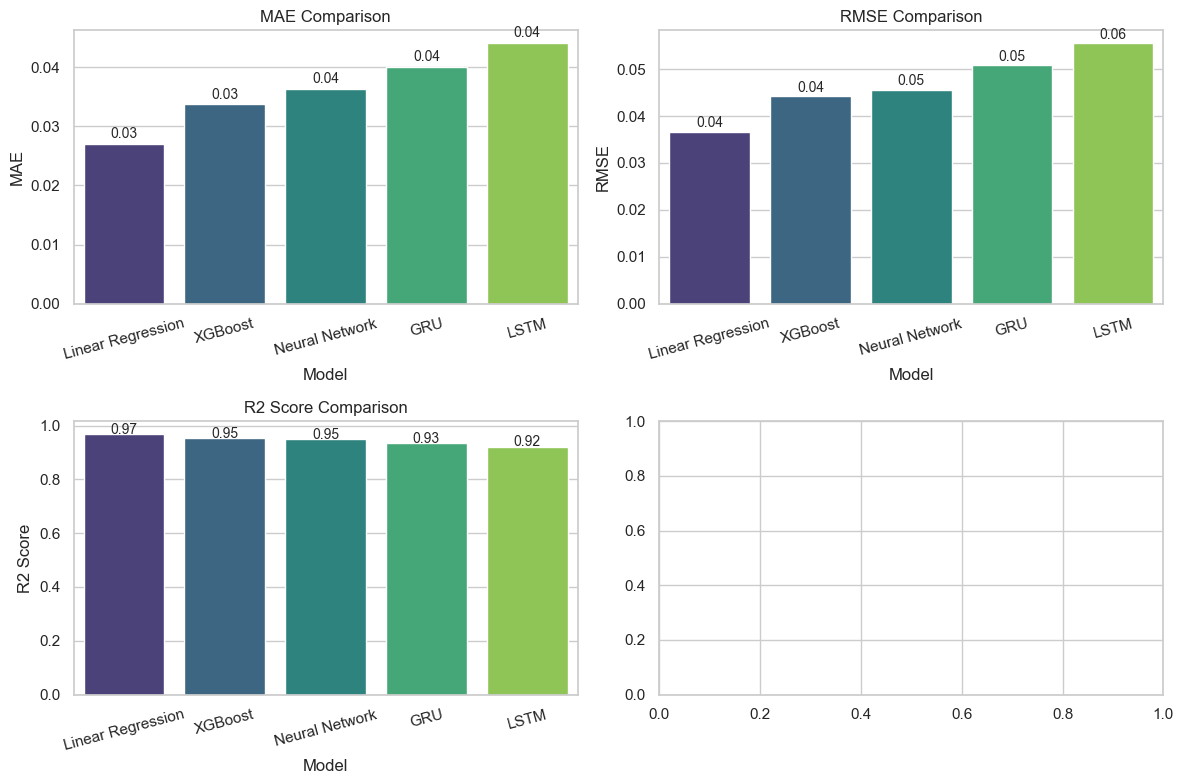

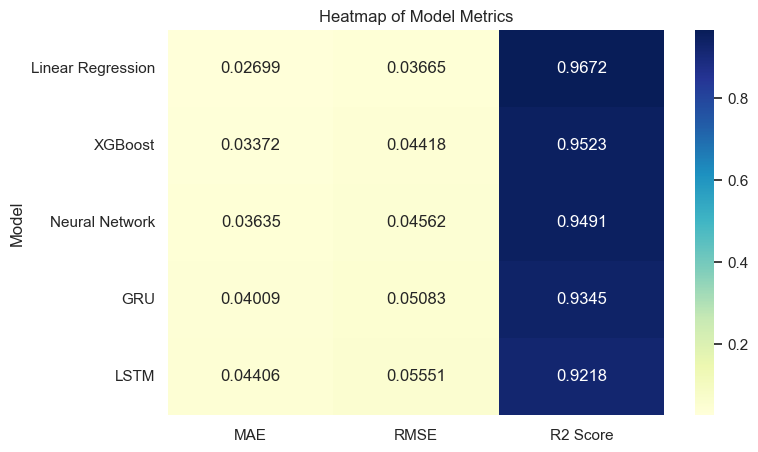

In [153]:
df = comparison_df

# Set seaborn style
sns.set_theme(style='whitegrid')

# ----------- 📊 Bar Chart for Each Metric -----------
metrics = ['MAE', 'RMSE', 'R2 Score']
fig, axs = plt.subplots(2,2, figsize=(12, 8))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    barplot = sns.barplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')
    ax.set_title(f'{metric} Comparison')
    ax.tick_params(axis='x', rotation=15)

    # Add value labels on top of bars
    for p in barplot.patches:
        value = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., value + 0.001, f'{value:.2f}', ha="center", fontsize=10)

plt.tight_layout()
plt.show()

# ----------- 🔥 Heatmap -----------
plt.figure(figsize=(8, 5))
sns.heatmap(df.set_index('Model'), annot=True, cmap='YlGnBu', fmt=".4g")
plt.title('Heatmap of Model Metrics')
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


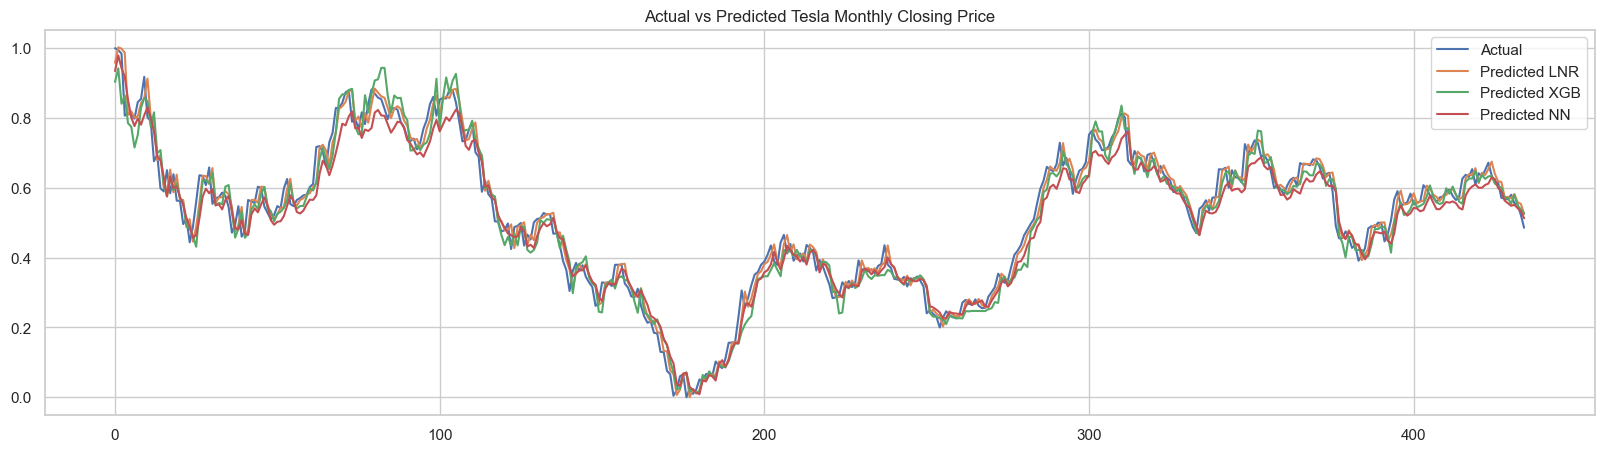

In [155]:
# Visual Comparison Traditional models
plt.figure(figsize=(20,5))
plt.plot(y_test_scaled.values, label='Actual')

y_pred = model_lnr.predict(X_test_scaled)
plt.plot(y_pred, label='Predicted LNR')
y_pred = model_xgb.predict(X_test_scaled)
plt.plot(y_pred, label='Predicted XGB')
y_pred = model_nn.predict(X_test_scaled)
plt.plot(y_pred, label='Predicted NN')

plt.title("Actual vs Predicted Tesla Monthly Closing Price")
plt.legend()
plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


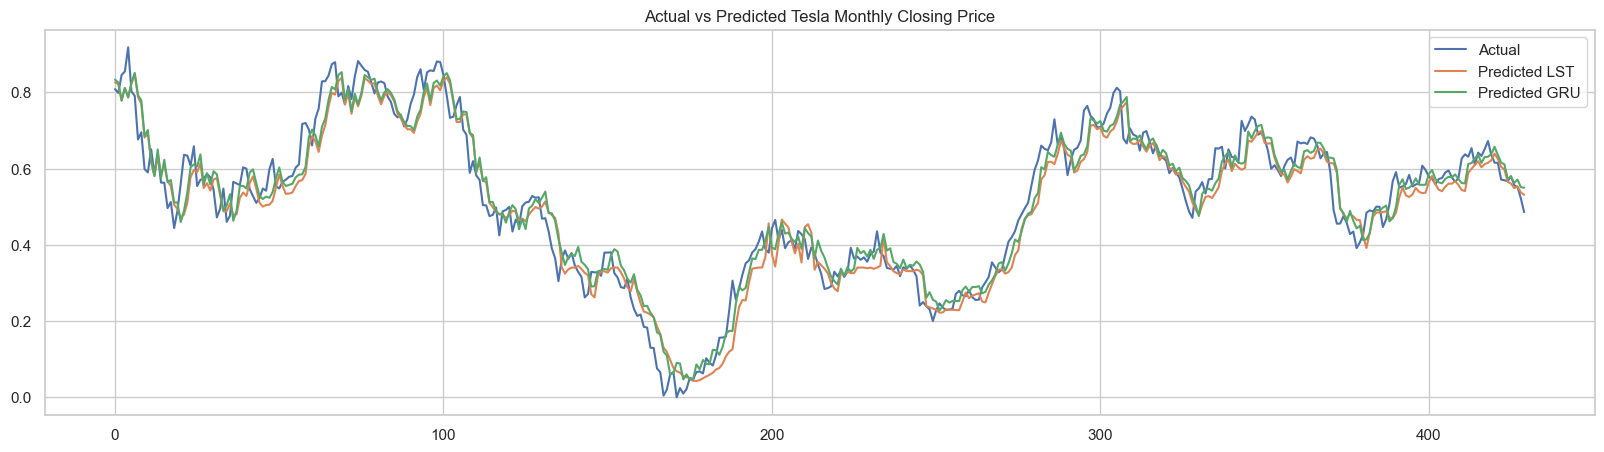

In [156]:
# Visual Comparison RNN based model
plt.figure(figsize=(20,5))
plt.plot(y_test_RNN.values, label='Actual')

y_pred = model_lstm.predict(X_test_RNN)
plt.plot(y_pred, label='Predicted LST')

y_pred = model_gru.predict(X_test_RNN)
plt.plot(y_pred, label='Predicted GRU')

plt.title("Actual vs Predicted Tesla Monthly Closing Price")
plt.legend()
plt.show()